In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py
%run {helper_dir}/mk_design_matrix.py
%run {helper_dir}/fit_data.py
%run {helper_dir}/run_lm_singlestep.py

## Input

In [4]:
chain = 'Avalanche'

In [5]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('AUM & Glp Supply'):
        fnames['AUM & Glp Supply'] = fname
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
    if fname.startswith('Fees'):
        fnames['Fees'] = fname
    if fname.startswith('Volume'):
        fnames['Volume'] = fname        
fnames

{'Glp Price Comparison': 'Glp Price Comparison_2022-01-06_2022-07-01.csv',
 'Volume': 'Volume_2022-01-06_2022-07-01.csv',
 'Fees': 'Fees_2022-01-06_2022-07-01.csv',
 'AUM & Glp Supply': 'AUM & Glp Supply_2022-01-06_2022-07-01.csv'}

In [6]:
# create input-dependent dirs
save_fig_dir = os.path.join(png_dir, chain)
os.makedirs(save_fig_dir, exist_ok=True)

## Prep Data

In [7]:
# In the 'AUM & Glp Supply' file, col `aum` is in $, and `glpSupply` in quantity/count; 
# each row is the total stock measured at the end of the day. 
#
# I checked that `aum` == `glpSupply` * `glpPrice`, where `glpPrice` is from the 'Glp Price Comparison' file.
# So this `aum` is only a GLP `aum`, and it doesn't include staked GMX. So it doesn't capture the full picture. 
# Let's ignore it.
# 
# To calculate the net GLP supply (mint amount - burn amount) for each day, 
# - take the difference of total stock of glpSupply between two consecutive dates. 
# To calculate the net dollar flow for each day, simply do
# - net supply * (daily avg) glp price, which can be taken from the price file.

daily_stock = pd.read_csv(os.path.join(data_dir, chain, fnames['AUM & Glp Supply']), 
                          parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpSupply'])
# drop the last row because the most recent date may not be a full day
daily_stock = daily_stock.iloc[:-1, :]
daily_stock.head()

,glpSupply
Date,
2022-01-06,"11,092,717.6851"
2022-01-07,"13,861,423.3623"
2022-01-08,"17,158,471.3889"
2022-01-09,"18,813,523.3498"
2022-01-10,"19,716,308.4581"


In [8]:
# calculate daily flow by taking the difference between today's stock and yesterday's 
daily_flow = daily_stock - daily_stock.shift(1)
daily_flow.head()

,glpSupply
Date,
2022-01-06,NaN
2022-01-07,"2,768,705.6771"
2022-01-08,"3,297,048.0266"
2022-01-09,"1,655,051.9609"
2022-01-10,"902,785.1084"


In [9]:
daily_prices = pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                           parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpPrice'])
daily_prices.head()

,glpPrice
Date,
2022-01-06,1.1710
2022-01-07,1.1558
2022-01-08,1.1452
2022-01-09,1.1532
2022-01-10,1.1072


In [10]:
# calculate net dollar flow for GLP
daily_flow = (pd.merge(daily_flow, daily_prices.loc[:, 'glpPrice'], left_index=True, right_index=True)
                .assign(net_dollar_flow = lambda x: x.glpSupply * x.glpPrice)
                .drop(['glpSupply', 'glpPrice'], axis=1)
                .dropna() # drop missing rows
             )
daily_flow.head()

,net_dollar_flow
Date,
2022-01-07,"3,199,948.2841"
2022-01-08,"3,775,635.3459"
2022-01-09,"1,908,672.2981"
2022-01-10,"999,538.7066"
2022-01-11,"7,027,282.7992"


## GLP Net Dollar Flow 

### Monthly

In [11]:
monthly_ndf = daily_flow.groupby(daily_flow.index.to_period('M')).net_dollar_flow.sum()
monthly_ndf

Date
2022-01   65,047,100.9291
2022-02       56,220.5607
2022-03    6,684,854.8585
2022-04   10,901,795.6929
2022-05    8,376,715.5955
2022-06   -7,551,629.7595
Freq: M, Name: net_dollar_flow, dtype: float64

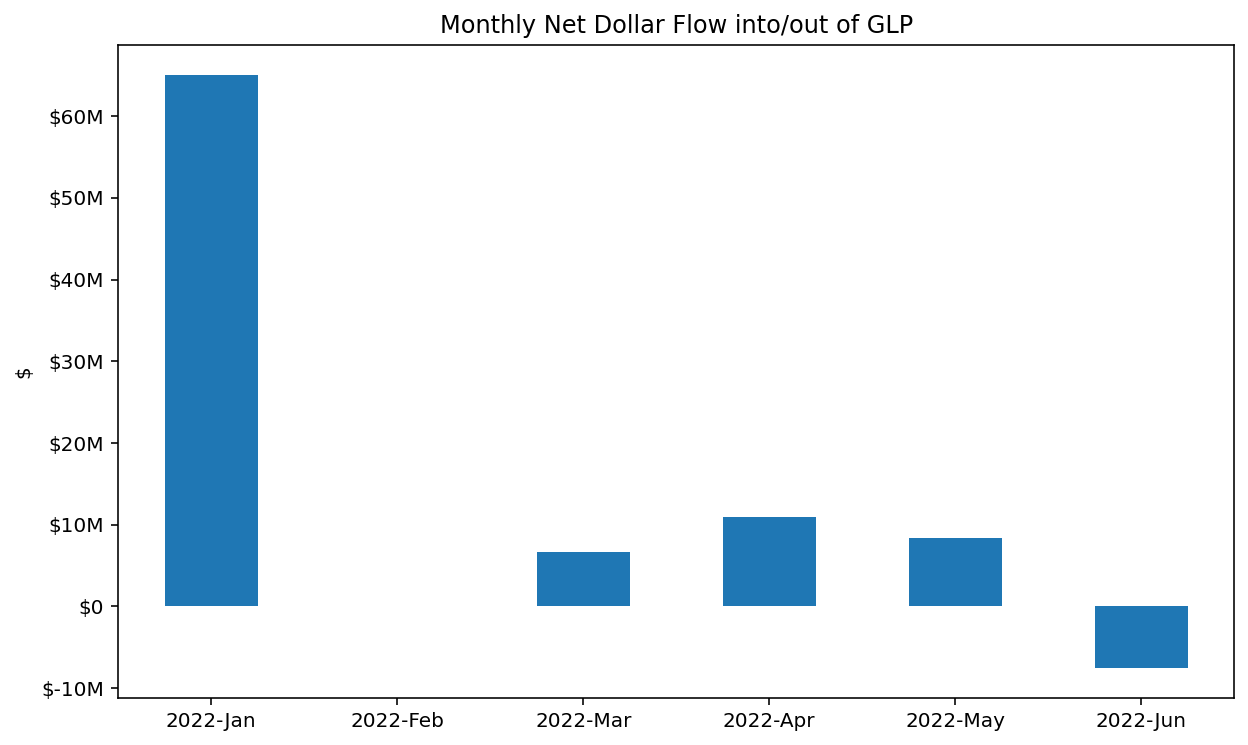

In [12]:
ax = monthly_ndf.plot(kind='bar',
                      title="Monthly Net Dollar Flow into/out of GLP",
                      ylabel='$', xlabel='', rot=0)
ax.set_xticklabels(monthly_ndf.index.to_timestamp().strftime('%Y-%b'))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
plt.savefig(os.path.join(save_fig_dir, 'monthly_ndf.png'), dpi=300);

- In January 2022, the first month GMX opened on Avalanche, more than `$65M` (net) flew into GLP.
- The net dollar flow was much less for the following months, with the best being `~$11M`.
- In June 2022, `~$7.5M` (net) left GLP as we entered the crypto bear market.

### Weekly

In [13]:
weekly_ndf = daily_flow.groupby(daily_flow.index.to_period('W')).net_dollar_flow.sum()
weekly_ndf.index.name = 'Week'
weekly_ndf.head()

Week
2022-01-03/2022-01-09    8,884,255.9281
2022-01-10/2022-01-16   22,982,531.9584
2022-01-17/2022-01-23    8,874,382.9356
2022-01-24/2022-01-30   22,429,401.3965
2022-01-31/2022-02-06    5,919,215.2339
Freq: W-SUN, Name: net_dollar_flow, dtype: float64

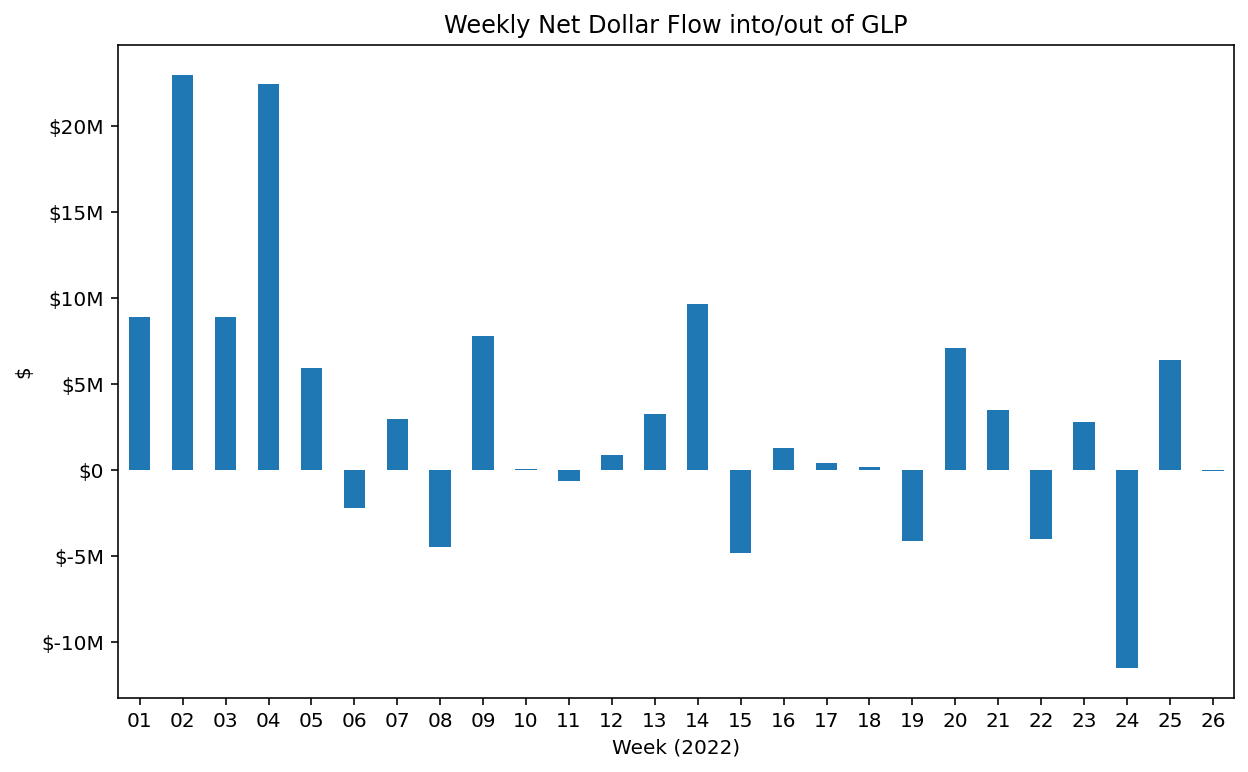

In [14]:
ax = weekly_ndf.plot(kind='bar', title="Weekly Net Dollar Flow into/out of GLP",
                     ylabel='$', xlabel='Week (2022)', rot=0)
ax.set_xticklabels(weekly_ndf.index.to_timestamp().strftime('%W'))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
plt.savefig(os.path.join(save_fig_dir, 'weekly_ndf.png'), dpi=300);

### Rolling Averages

In [15]:
daily_flow['rolling_avg_7d'] = daily_flow.net_dollar_flow.rolling(7).mean()
daily_flow['rolling_avg_14d'] = daily_flow.net_dollar_flow.rolling(14).mean()
daily_flow['rolling_avg_30d'] = daily_flow.net_dollar_flow.rolling(30).mean()
daily_flow.head()

,net_dollar_flow,rolling_avg_7d,rolling_avg_14d,rolling_avg_30d
Date,,,,
2022-01-07,"3,199,948.2841",NaN,NaN,NaN
2022-01-08,"3,775,635.3459",NaN,NaN,NaN
2022-01-09,"1,908,672.2981",NaN,NaN,NaN
2022-01-10,"999,538.7066",NaN,NaN,NaN
2022-01-11,"7,027,282.7992",NaN,NaN,NaN


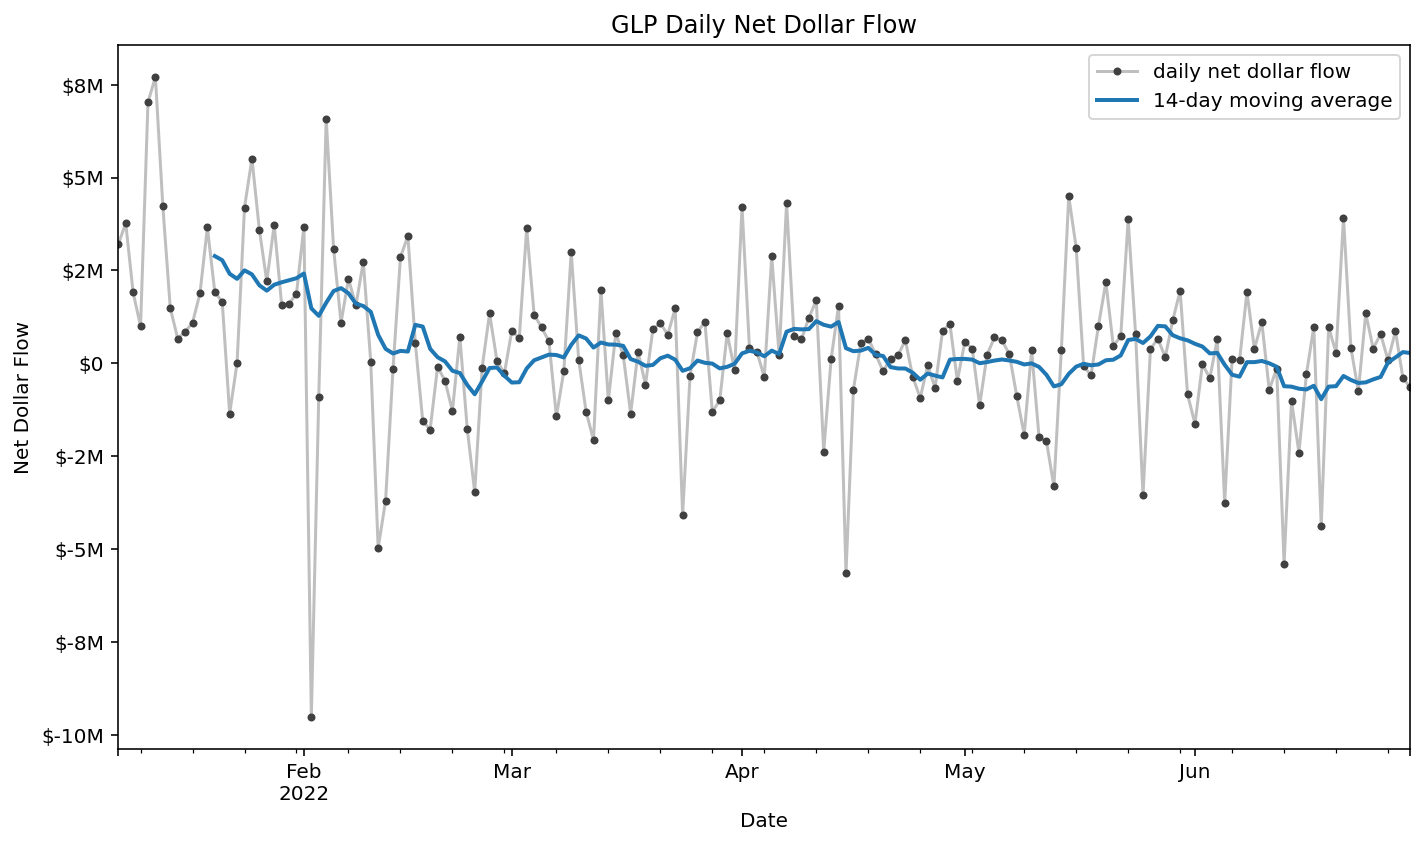

In [16]:
ax = plot_timeseries_with_trendline(
    daily_flow.net_dollar_flow, yhat=daily_flow.rolling_avg_14d, 
    title='GLP Daily Net Dollar Flow', ylabel='Net Dollar Flow', 
    ytru_legend='daily net dollar flow', 
    yhat_legend='14-day moving average')
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'ndf_14d_mavg.png'), dpi=300);

## Forecast GLP Net Dollar Flow for Next Day

In [17]:
y = daily_flow.net_dollar_flow
y.head()

Date
2022-01-07   3,199,948.2841
2022-01-08   3,775,635.3459
2022-01-09   1,908,672.2981
2022-01-10     999,538.7066
2022-01-11   7,027,282.7992
Name: net_dollar_flow, dtype: float64

### Use Linear Trend and Day of Week as Predictors

In [18]:
# the moving avg plot shows a mild exponential trend, to avoid overfit, let's simply try a linear trend
X_trend = mk_X_trend_seasonality(y.index)
X_trend.head()

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)"
Date,,,,,,,,
2022-01-07,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2022-01-08,2.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2022-01-09,3.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
2022-01-10,4.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
2022-01-11,5.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


Train RMSE: 2177321.86
Test RMSE: 1831563.19


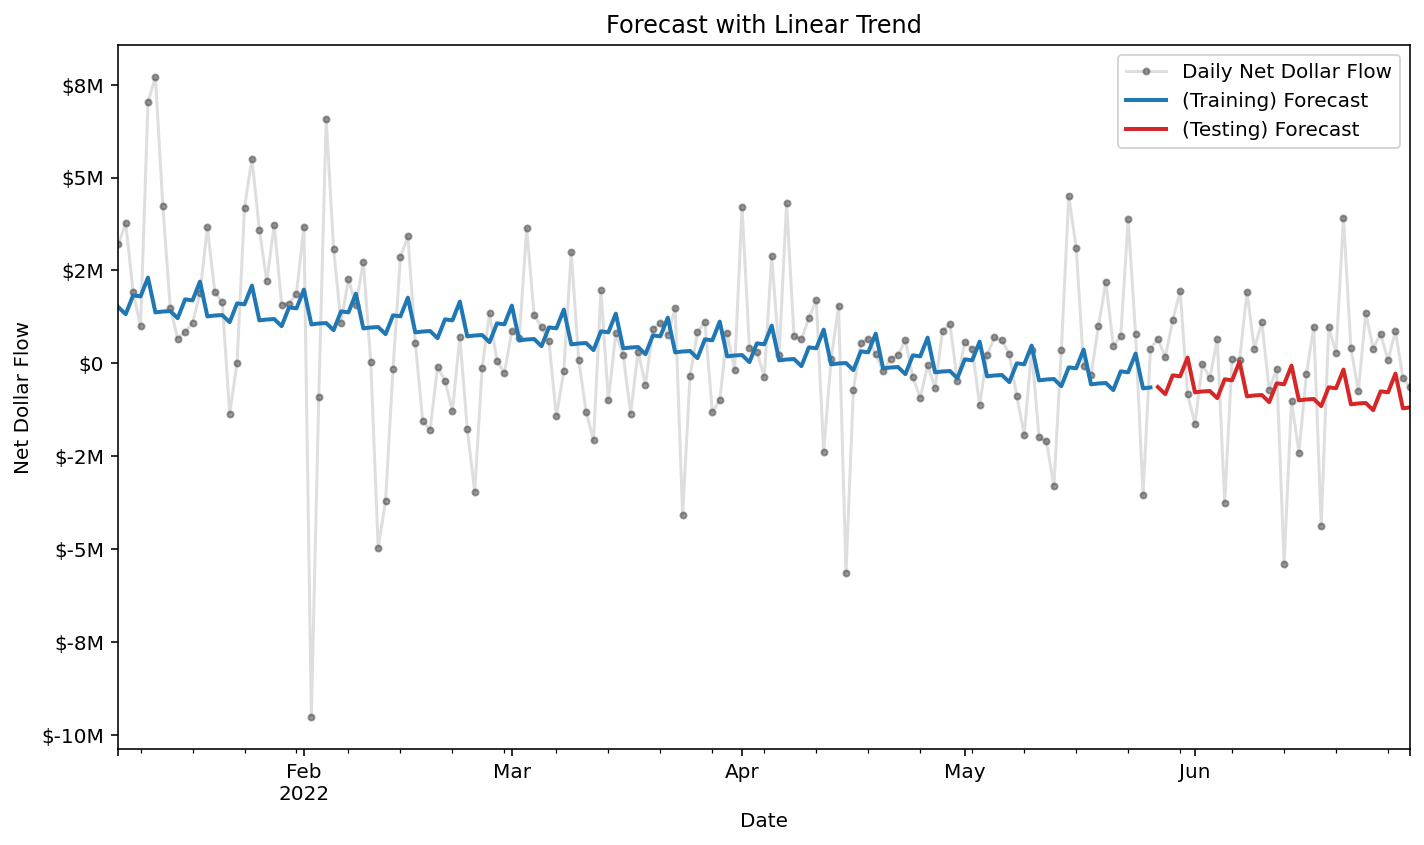

In [19]:
# train linear regression on first 80% of the data and test on the rest 20%, preserving time order  
y_train, yhat_train, y_test, yhat_test = run_lm_singlestep(X_trend, y, test_size=0.2)

# visualize model predictions against truth
ax = plot_pred_singlestep(y, yhat_train, yhat_test, title='Forecast with Linear Trend',
                          ylabel='Net Dollar Flow', ytru_legend='Daily Net Dollar Flow')
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, '01_daily_ndf_trend_forecast.png'), dpi=300);

### Use past values of target as predictors

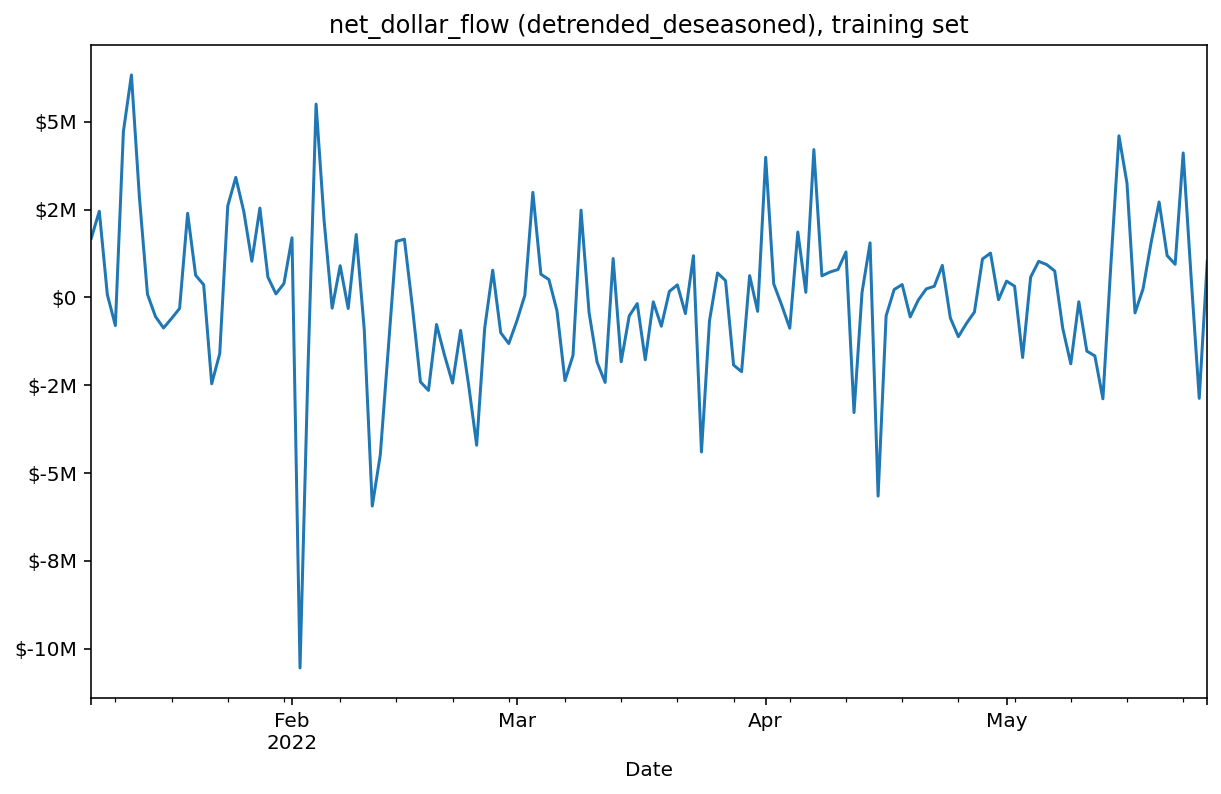

In [20]:
# first, we need to remove trend and seasonality from the target
y_train = y_train - yhat_train
y_train.name = 'detrended_deseasoned'
y_test = y_test - yhat_test
y_test.name = 'detrended_deseasoned'

# look at the detrended data, is there any pattern?
ax = y_train.plot()
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
ax.set_title(f'{y.name} ({y_train.name}), training set');

In [21]:
y = pd.concat([y_train, y_test]) # for feature generation convenience

In [22]:
# try 1-day lagged series
X = make_lags(y, lags=3).dropna()

# only take records whose time indices exist on both X and y
y, X = y.align(X, join='inner')
print(X.head(), end='\n\n')
print(y.head())

                  y_lag_1        y_lag_2        y_lag_3
Date                                                   
2022-01-10    78,116.3239 2,451,495.4071 1,684,227.8813
2022-01-11  -804,059.3529    78,116.3239 2,451,495.4071
2022-01-12 4,719,662.6735  -804,059.3529    78,116.3239
2022-01-13 6,333,745.5189 4,719,662.6735  -804,059.3529
2022-01-14 2,837,358.6727 6,333,745.5189 4,719,662.6735

Date
2022-01-10    -804,059.3529
2022-01-11   4,719,662.6735
2022-01-12   6,333,745.5189
2022-01-13   2,837,358.6727
2022-01-14      87,804.6892
Name: detrended_deseasoned, dtype: float64


In [23]:
# train linear regression to predict the de-trended target with seasonal features
y_train, yhat_train, y_test, yhat_test = run_lm_singlestep(X, y, test_size=0.2)

Train RMSE: 2057273.87
Test RMSE: 1970898.07


<AxesSubplot:title={'center':'Seasonality'}, xlabel='Date', ylabel='detrended_deseasoned'>

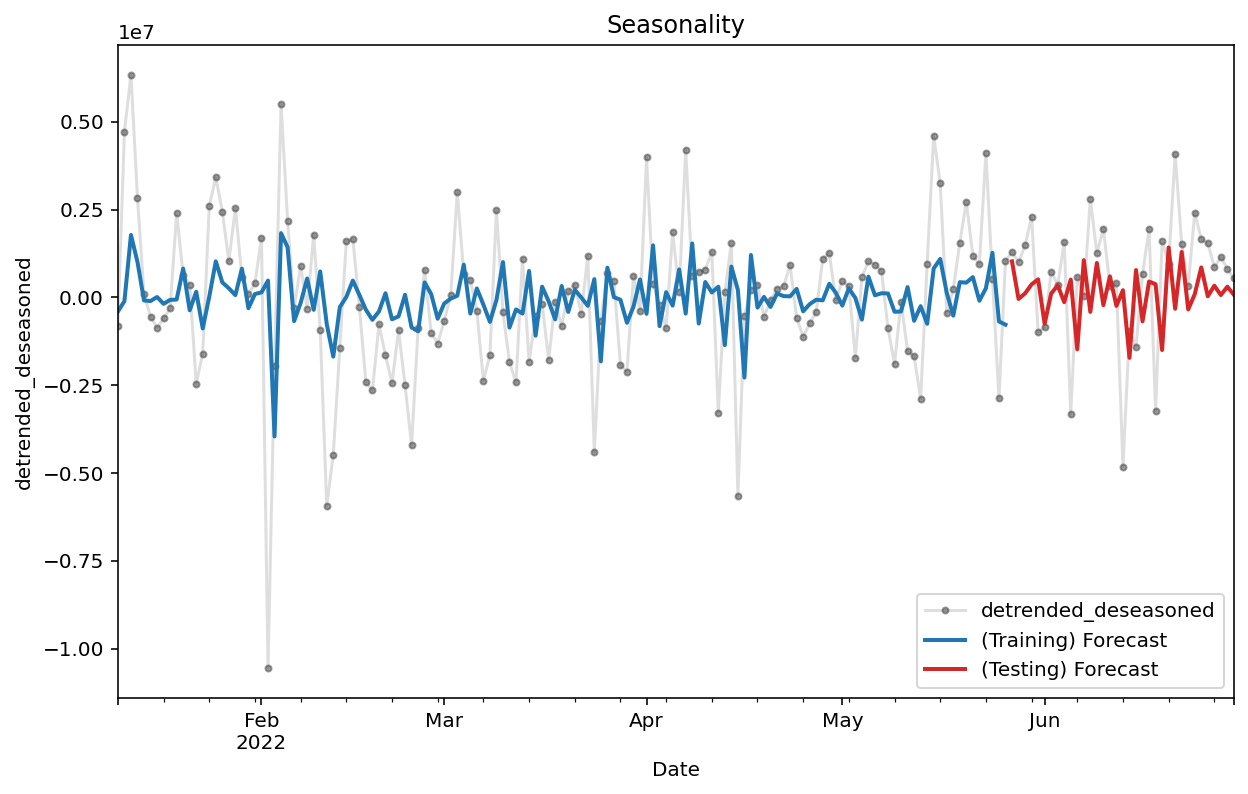

In [24]:
# visualize model predictions against truth
plot_pred_singlestep(y, yhat_train, yhat_test, title='Seasonality')